# VANA Assignment - Gradient Descent

Das Ziel dieser Aufgabe besteht darin, dass Sie ein grundlegendes Verständnis für numerische Näherungsverfahren in höheren Dimensionen erlangen, insbesondere für den Gradient Descent und dessen praktische Anwendung. Hierfür sollen Sie ein Jupyter Notebook erstellen und das MNIST Dataset laden und erkunden. Anschließend sollen Sie ein neuronales Netzwerk erstellen und trainieren, um die Bilder korrekt zu klassifizieren. Es dürfen nur die angegebenen Python Pakete verwendet werden.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import MNIST 


## Aufgabe 1

Laden Sie das MNIST-Dataset (Training und Test) mithilfe des torchvision-Pakets (Verwenden Sie das torchvision Paket nur für diese Aufgabe) und verwenden Sie matplotlib, um sich einen Überblick über die Daten zu verschaffen. Beschreiben Sie die grundlegenden Eigenschaften des Datensets, z.B. wie viele und welche Daten es enthält und wie diese verteilt sind.

Anzahl der Trainingsbilder: 60000
Anzahl der Testbilder: 10000
Größe der Bilder: (28, 28)


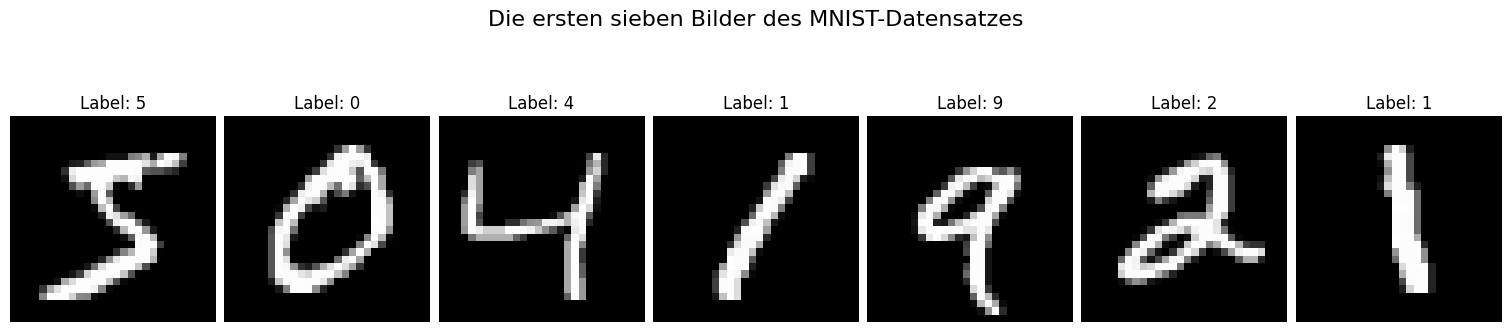

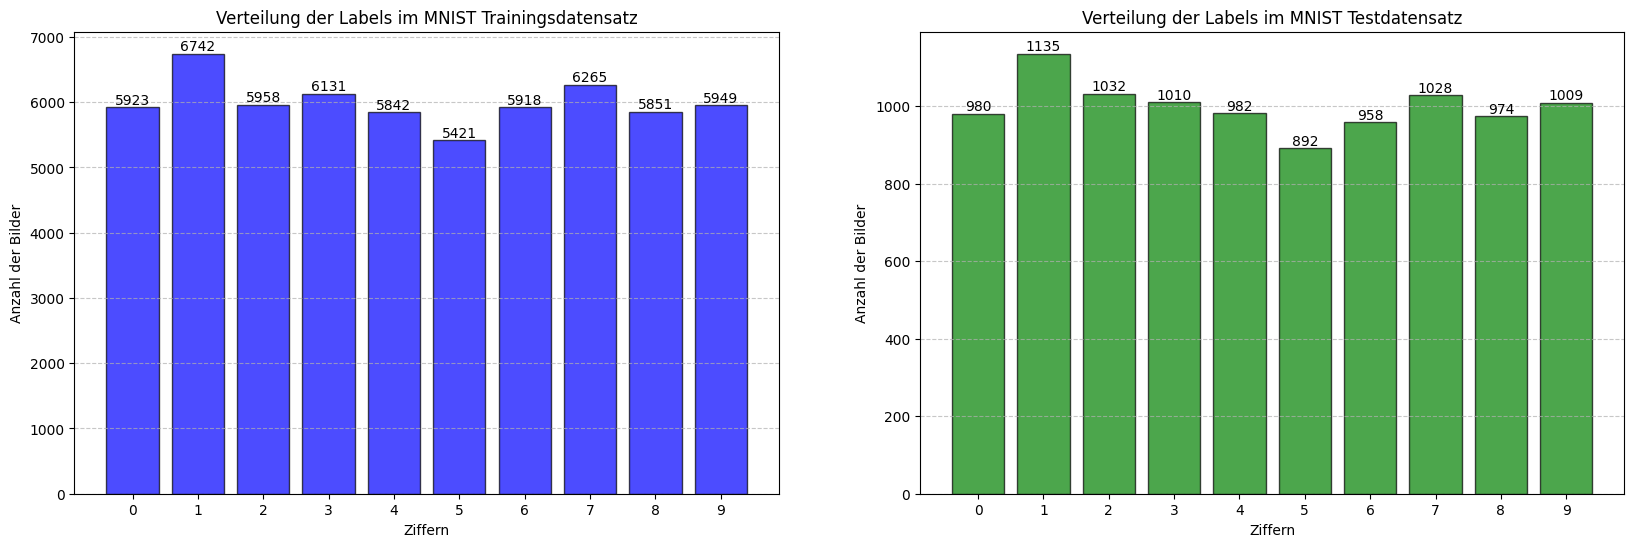

In [91]:
mnist_train = MNIST(root='./data', train=True, download=True)
mnist_test = MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data.numpy()
train_labels = mnist_train.targets.numpy()
test_data = mnist_test.data.numpy()
test_labels = mnist_test.targets.numpy()

print(f'Anzahl der Trainingsbilder: {len(train_data)}')
print(f'Anzahl der Testbilder: {len(test_data)}')
print(f'Größe der Bilder: {train_data[0].shape}')

# Example images

fig, axes = plt.subplots(1, 7, figsize=(15, 4), constrained_layout=True)
for i, ax in enumerate(axes):
    ax.imshow(train_data[i], cmap='gray')
    ax.title.set_text(f'Label: {train_labels[i]}')
    ax.axis('off')
plt.suptitle('Die ersten sieben Bilder des MNIST-Datensatzes', fontsize=16)

# Distribution of the Data

fig, axes = plt.subplots(1, 2, figsize=(20, 6)) 
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

bars_train = axes[0].bar(np.arange(10), train_counts, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Verteilung der Labels im MNIST Trainingsdatensatz')
axes[0].set_xlabel('Ziffern')
axes[0].set_ylabel('Anzahl der Bilder')
axes[0].bar_label(bars_train)
axes[0].set_xticks(np.arange(10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

bars_test = axes[1].bar(np.arange(10), test_counts, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Verteilung der Labels im MNIST Testdatensatz')
axes[1].set_xlabel('Ziffern')
axes[1].set_ylabel('Anzahl der Bilder')
axes[1].bar_label(bars_test)
axes[1].set_xticks(np.arange(10))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Aufgabe 2

Erstellen Sie eine Klasse für ein lineares Layer mit beliebig vielen Knoten. Implementieren Sie darin getrennte Methoden für Forward-Pass, Backward-Pass und Parameter-Update mithilfe von numpy. Schreiben Sie geeignete Unittests, um die Funktionsweise dieser Funktionen zu prüfen. Schreiben Sie insbesondere einen expliziten Test, für ein Layer mit 2 Knoten, welches als Input 2 Datensätzen zu je zwei 2 floats erhält. Wählen Sie dazu unterschiedliche feste Werte für Input, initiale Gewichte und Lernrate. Dann berechnen sie von Hand die Ergebnisse von Forward, Backward und Update und testen damit ihre Implementation. Legen Sie die Berechnung der Ergebnisse ihrer Lösung bei.

### Forward-Pass

**Input**: Matrix von N Datenpunkten mit I Dimensionen

$$N: \text{Anzahl der Datenpunkte} = 60000 $$
$$I: \text{Anzahl der Datenpunkte in einem Datenpunkt} = 28 \cdot 28 = 784 $$
$$X: N \times I = 60000 \times 784 $$

**Output**: Matrix der N mit O Dimensionen
$$O: \text{Outputwerte pro Punkt / Kerne / Knoten} $$
$$z: N \times O $$

**implementation**: Vektorschreibweise 
$$z = x \cdot w + b $$
$$\text{Gewichte}\ w: 1 \times O\ \text{Matrix} $$
$$\text{Biases}\ b: O \text{ Vektor}\ \rightarrow (1,0)\text{Matrix} $$
$$\text{beides im self} $$

Komponentenschreibweise:
$$i: \text{Index des Datensatz} $$
$$l: \text{index des Outputs} $$
$$z_{il} = \sum_{k=1}^{I} (x_{ik} \cdot w_{kl} + b_l) $$

### Backward-Pass

**Input**: Ableitung des Loss nach dem Output des Layers
$$\frac{\partial Loss}{\partial z}: N \times O \text{ Matrix}$$

**Output**: Ableitung des Loss nach den Parametern $w$, $b$ sowie nach input $x$
$$db: O \text{ Vektor} \rightarrow (1,0)\text{Matrix} = \frac{\partial Loss}{\partial b} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial b}$$
$$dw: I \times O \text{ Matrix} = \frac{\partial Loss}{\partial w} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial w}$$
$$dx: N \times I \text{ Matrix} = \frac{\partial Loss}{\partial x} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial x}$$

**implementation**: $dx$ ausgeben, $dw$ und $db$ in self Speichern
$$db = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial b} = \sum_{i=1}^N \frac{\partial Loss}{\partial z}$$
$$dw = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial w} = X^T \frac{\partial Loss}{\partial z}$$
$$dx = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial x} = \frac{\partial Loss}{\partial z} W^T \text{ da gilt}:\frac{\partial z}{\partial x} = W^T$$

### Parameter-Update

**Input**: Ableitungen des Loss nach den Parametern und Lernrate

$$\alpha: Lernrate$$

**Output**: Veränderte Parameter

$$w \rightarrow w - \alpha \frac{\partial Loss}{\partial w}$$
$$b \rightarrow b - \alpha \frac{\partial Loss}{\partial b}$$

**Implementation**: Parameter und Ableitung in Klasse speichern. Update Funktion ist ohne expliziten Output, Input ist nur die Lernrate

$$w = w - \alpha\ dw$$
$$b = b - \alpha\ db$$

In [92]:
class LinearLayer:
    def __init__(self, input_size: int, output_size: int) -> None:
        self.input_data = None
        self.output = None
        self.weights = np.random.randn(output_size, input_size) / np.sqrt(input_size)
        self.biases = np.zeros((output_size, 1))
        self.grad_weights = None
        self.grad_biases = None
    
    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        self.input_data = input_data
        self.output = np.dot(self.weights, input_data) + self.biases
        return self.output
    
    def backward_pass(self, grad_output: np.ndarray) -> np.ndarray:
        grad_input = np.dot(self.weights.T, grad_output)
        self.grad_weights = np.dot(grad_output, self.input_data.T)
        self.grad_biases = np.sum(grad_output, axis=1, keepdims=True)
        return grad_input
    
    def parameter_update(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases


## Test für den Linear Layer

### Expliziter Test

Berechnung des Forwards:

$$ W = \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} $$
$$ b = \begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} $$
$$ X = \begin{bmatrix} 0.7 & 0.8 \\ 0.9 & 1.0 \end{bmatrix} $$ 
$$ 
\text{output} = W \cdot X + b = 
\begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} \cdot \begin{bmatrix} 0.7 & 0.8 \\ 0.9 & 1.0 \end{bmatrix} + \begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} = 
\begin{bmatrix} 0.25 & 0.28 \\ 0.57 & 0.64 \end{bmatrix} + \begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} =
\begin{bmatrix} 0.75 & 0.78 \\ 1.17 & 1.24 \end{bmatrix}
$$

Berechnung des Backwards:

$$ \text{grad_output} = \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} $$
$$ 
\text{grad_input} = W^T \cdot \text{input_data} = 
\begin{bmatrix} 0.1 & 0.3 \\ 0.2 & 0.4 \end{bmatrix} \cdot \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} =
\begin{bmatrix} 0.1 & 0.14 \\ 0.14 & 0.2 \end{bmatrix}
$$

Berechnung des Parameter Updates:

$$ 
\text{grad_weights} = \text{grad_output} \cdot X^T =
\begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} \cdot \begin{bmatrix} 0.7 & 0.9 \\ 0.8 & 1.0 \end{bmatrix} =
\begin{bmatrix} 0.86 & 0.29 \\ 0.53 & 0.67 \end{bmatrix}
$$
$$ 
\text{grad_biases} = \begin{bmatrix} \sum \text{grad\_output}_{1j} \\ \sum \text{grad\_output}_{2j} \end{bmatrix} = 
\begin{bmatrix} 0.3 \\ 0.7 \end{bmatrix}
$$
$$ \text{learning_rate} = 0.1 $$
$$
W_{updated} = W - \text{learning_rate} \cdot \text{grad_weights} =
\begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} - 0.1 \cdot \begin{bmatrix} 0.86 & 0.29 \\ 0.53 & 0.67 \end{bmatrix} =
\begin{bmatrix} 0.077 & 0.171 \\ 0.247 & 0.333 \end{bmatrix}
$$
$$
b_{updated} = b - \text{learning_rate} \cdot \text{grad_biases} =
\begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} - 0.1 \cdot \begin{bmatrix} 0.3 \\ 0.7 \end{bmatrix} =
\begin{bmatrix} 0.47 \\ 0.63 \end{bmatrix}
$$

In [93]:
import unittest

class TestLinearLayer(unittest.TestCase):
    def test_forward_pass(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])
        expected_output = np.dot(layer.weights, input_data) + layer.biases
        np.testing.assert_array_almost_equal(layer.forward_pass(input_data), expected_output, decimal=5)

    def test_backward_pass(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])
        layer.forward_pass(input_data)
        grad_output = np.array([[0.1, 0.2], [0.3, 0.4]])
        expected_grad_input = np.dot(layer.weights.T, grad_output)
        np.testing.assert_array_almost_equal(layer.backward_pass(grad_output), expected_grad_input, decimal=5)

    def test_parameter_update(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])
        layer.forward_pass(input_data)
        grad_output = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.backward_pass(grad_output)
        learning_rate = 0.1
        expected_weights = layer.weights - learning_rate * layer.grad_weights
        expected_biases = layer.biases - learning_rate * layer.grad_biases
        layer.parameter_update(learning_rate)
        np.testing.assert_array_almost_equal(layer.weights, expected_weights, decimal=5)
        np.testing.assert_array_almost_equal(layer.biases, expected_biases, decimal=5)

    def test_linear_layer(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])

        # Test forward_pass
        expected_output_forward = np.array([[0.75, 0.78], [1.17, 1.24]])
        np.testing.assert_array_almost_equal(layer.forward_pass(input_data), expected_output_forward, decimal=5)

        # Test backward_pass
        grad_output = np.array([[0.1, 0.2], [0.3, 0.4]])
        expected_grad_input = np.array([[0.1, 0.14], [0.14, 0.2]])
        np.testing.assert_array_almost_equal(layer.backward_pass(grad_output), expected_grad_input, decimal=5)

        # Test parameter_update
        learning_rate = 0.1
        expected_weights = np.array([[0.077, 0.171], [0.247, 0.333]])
        expected_biases = np.array([[0.47], [0.53]])
        layer.parameter_update(learning_rate)
        np.testing.assert_array_almost_equal(layer.weights, expected_weights, decimal=5)
        np.testing.assert_array_almost_equal(layer.biases, expected_biases, decimal=5)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


## Aufgabe 3

Erstellen Sie ein neuronales Netzwerk mit 3 Hidden Layern mit gleicher Anzahl Knoten und einem Output Layer mit 10 Knoten. Verwenden Sie dazu die in Aufgabe 2 implementierte Klasse. Das Ziel ist die korrekte Klassifizierung aller Ziffern. Bereiten Sie die Trainingsloop und alles dafür benötigte vor, um das Netzwerk darauf zu trainieren. Das heißt, jeder Output Knoten wird einer Ziffer zugeordnet; der Output soll 1 für diese Ziffer und 0 für alle anderen Ziffern sein. Das Netzwerk soll auf den Trainingsdaten trainieren und auf den Testdaten evaluiert werden. Achten Sie beim Training darauf, nicht auf dem gesamten Datensatz gleichzeitig zu trainieren, sondern stückeln Sie diesen in kleine Portionen (batches), auf denen nacheinander trainiert wird. Erläutern Sie kurz, warum das nötig ist. Verwenden Sie eine geeignete Kosten-Funktion sowie Evaluations-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl dieser Funktion und diskutieren Sie kurz eine weitere Option für Kosten und Evaluation mit einer Abwägung der Vor- und Nachteile.

### Vorbereitung der Trainings- und Label-Daten

Damit die Label-Daten während des Trainings verwendet werden können, um mithilfe der Kostenfunktion die Abweichung, also die Differenz zwischen den vorhergesagten und den tatsächlichen Werten, zu berechnen, müssen sie zunächst mittels One-Hot-Encoding kodiert werden.


In [94]:
def one_hot_encode(labels: np.ndarray) -> np.ndarray:
    one_hot_labels = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        one_hot_labels[i, label] = 1
    return one_hot_labels


In [95]:
def preprocess_data(dataset: MNIST) -> tuple:
    data = dataset.data.numpy()
    data = data.reshape(data.shape[0], -1)
    data = data / 255.0
    data = data.T
    labels = dataset.targets.numpy()
    encoded_labels = one_hot_encode(labels)
    return data, encoded_labels, labels

d, el, l = preprocess_data(mnist_train)


### Aktivierungsfunktionen

#### Aktivierungsfunktion für die hidden Layer: RelU

$$ \text{ReLU}(x) = \max(0, x) $$
$$ \text{ReLU}'(x) = \begin{cases} 1\ & \text{if } x > 0 \\ 0\ & \text{if } x \leq 0 \end{cases} $$


In [96]:
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

def relu_derivative(x: np.ndarray) -> np.ndarray:
    return np.where(x > 0, 1, 0)


#### Aktivierungsfunktion für den Output Layer: Softmax

$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

In [97]:
def softmax(z: np.ndarray) -> np.ndarray:
    z_max = np.max(z, axis=0, keepdims=True)
    e_pow_z = np.exp(z - z_max)
    return e_pow_z / np.sum(e_pow_z, axis=0, keepdims=True)


### Aufbau des Neuronalen Netzes

In [98]:
class NeuralNetwork:
    def __init__(self, hidden_size: int, input_size: int = 784, output_size: int = 10, nof_hidden_layers: int = 3):
        self.layers = []
        for i in range(nof_hidden_layers):
            self.layers.append(LinearLayer(input_size if i == 0 else hidden_size, hidden_size))
        self.layers.append(LinearLayer(hidden_size, output_size))
        
    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        for layer in self.layers[:-1]:
            input_data = relu(layer.forward_pass(input_data))
        return softmax(self.layers[-1].forward_pass(input_data))
    
    def backward_pass(self, grad_output: np.ndarray) -> np.ndarray:
        grad_output = self.layers[-1].backward_pass(grad_output)
        for layer in reversed(self.layers[:-1]):
            grad_output = relu_derivative(layer.output) * grad_output
            grad_output = layer.backward_pass(grad_output)
        return grad_output
    
    def parameter_update(self, learning_rate: float) -> None:
        for layer in self.layers:
            layer.parameter_update(learning_rate)


### Loss Funktion

Für die Loss Funktion eignet sich die Cross Entropy Loss Funktion.

In [99]:
class CrossEntropyLoss:
    def __init__(self):
        self.softmax_output = None
        self.targets = None
        self.predictions = None

    def forward(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        eps = 1e-8
        self.targets = targets
        self.predictions = predictions
        n = predictions.shape[1]
        loss = -np.log(predictions[targets, range(n)] + eps)
        loss = np.mean(loss)
        return loss

    def derivative(self) -> np.ndarray:
        d_softmax = self.predictions
        n = d_softmax.shape[1]
        d_softmax[self.targets, range(n)] -= 1
        d_softmax /= n
        return d_softmax


### Trainings-Loop

In [100]:
def train(network: NeuralNetwork, training_data: np.ndarray, training_labels: np.ndarray, unencoded_labels: np.ndarray, learning_rate: float, batch_size: int, loss_function) -> float:
    loss = 0
    for start in range(0, len(training_data), batch_size):
        end = start + batch_size
        batch_data = training_data[:,start:end]
        batch_labels = training_labels[start:end]
        batch_ulabels = unencoded_labels[start:end]
        
        output = network.forward_pass(batch_data)
        
        loss += loss_function.forward(output, batch_ulabels)
        grad_loss = loss_function.derivative()
        
        network.backward_pass(grad_loss)

        network.parameter_update(learning_rate)
    
    return loss


## Aufgabe 4

Trainieren Sie das Netzwerk mit verschiedenen Lernraten (0.01 - 1) und Größen der Hidden Layer (4, 8, 16). Verfolgen Sie während des Trainings die Entwicklung der Kosten- und Evaluations-Funktionen sowohl auf Trainings- als auch auf Testdaten. Interpretieren Sie die Ergebnisse des Netzwerks und entscheiden Sie, welche Wahl von Lernrate und Hidden Layer-Größe die Beste ist. Begründen Sie Ihre Wahl.

### Evaluationsfunktion


In [101]:
def evaluate_accuracy(network: NeuralNetwork, data: np.ndarray, labels: np.ndarray) -> float:
    outputs = network.forward_pass(data)
    predictions = np.argmax(outputs, axis=0)
    return np.mean(predictions == labels) * 100


In [102]:
def confusion_matrix(prediction: np.ndarray, true_labels: np.ndarray) -> None:
    pred_labels = np.argmax(prediction, axis=0)

    num_classes = prediction.shape[0]

    cm = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(true_labels)):
        cm[true_labels[i], pred_labels[i]] += 1

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(np.arange(num_classes))
    ax.set_yticklabels(np.arange(num_classes))

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.show()
 

In [103]:
def train_with_epoch(hidden_size: int, learning_rate: float, epochs: int = 32, batch_size: int = 30) -> tuple:
    network = NeuralNetwork(hidden_size)
    training_data, training_labels, unencoded_labels = preprocess_data(mnist_train)
    testing_data, testing_elabels, testing_labels = preprocess_data(mnist_test)
    loss_function = CrossEntropyLoss()

    training_losses = []
    testing_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        perm = np.random.permutation(training_data.shape[1]) 
        shuffled_data = training_data[:, perm]
        shuffled_labels = training_labels[perm]
        shuffled_unencoded_labels = unencoded_labels[perm]

        loss = train(network, shuffled_data, shuffled_labels, shuffled_unencoded_labels, learning_rate, batch_size, loss_function)
        training_losses.append(loss)
        testing_losses.append(loss_function.forward(network.forward_pass(testing_data), testing_labels))
        accuracies.append(evaluate_accuracy(network, testing_data, testing_labels))

    training_losses = np.array(training_losses)
    training_losses /= epochs # normalize the training_losses, this makes it easier to compare them to testing_losses
    print(f"Learning Rate: {learning_rate}, Hidden Layer Size: {hidden_size}, Epochs: {epochs}, ")
    print(f"Final Training Loss: {training_losses[-1]}, Final Testing Loss: {testing_losses[-1]}, Final Accuracy: {accuracies[-1]}%")
    print(" ")
    confusion_matrix(network.forward_pass(testing_data), testing_labels)
    return training_losses, testing_losses, accuracies


Learning Rate: 0.11, Hidden Layer Size: 8, Epochs: 32, 
Final Training Loss: 0.38345802157280595, Final Testing Loss: 0.41407197993173295, Final Accuracy: 87.94999999999999%
 


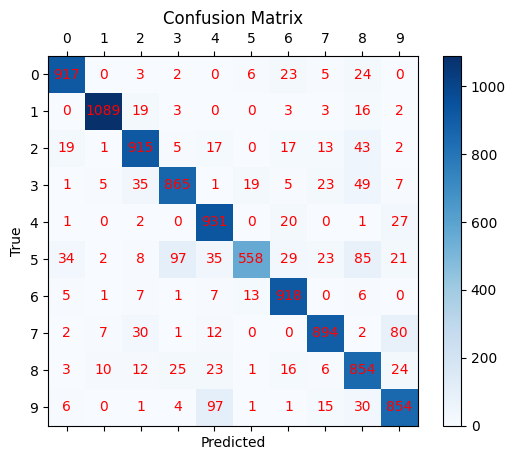

Learning Rate: 0.11, Hidden Layer Size: 16, Epochs: 32, 
Final Training Loss: 0.2371699659033728, Final Testing Loss: 0.2877216976418263, Final Accuracy: 91.24%
 


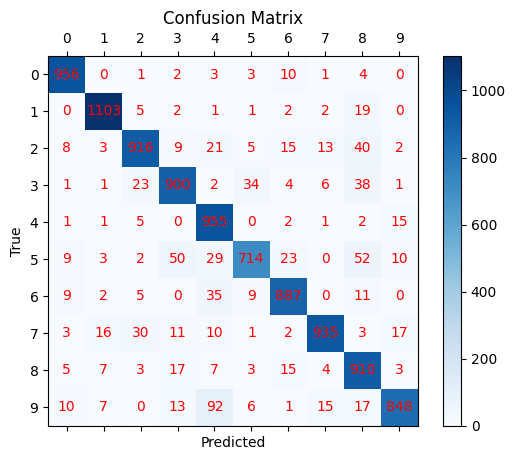

Learning Rate: 0.11, Hidden Layer Size: 32, Epochs: 32, 
Final Training Loss: 0.2112478794341793, Final Testing Loss: 0.2782551443312173, Final Accuracy: 91.82000000000001%
 


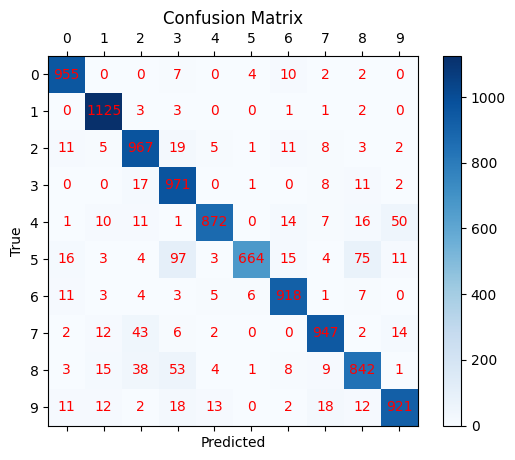

Learning Rate: 0.33, Hidden Layer Size: 8, Epochs: 32, 
Final Training Loss: 0.4925675397772171, Final Testing Loss: 0.7334437884071059, Final Accuracy: 78.3%
 


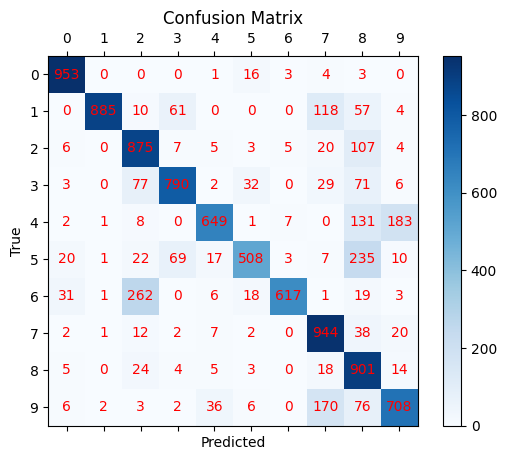

Learning Rate: 0.33, Hidden Layer Size: 16, Epochs: 32, 
Final Training Loss: 0.328934003564085, Final Testing Loss: 0.45042222094427586, Final Accuracy: 87.0%
 


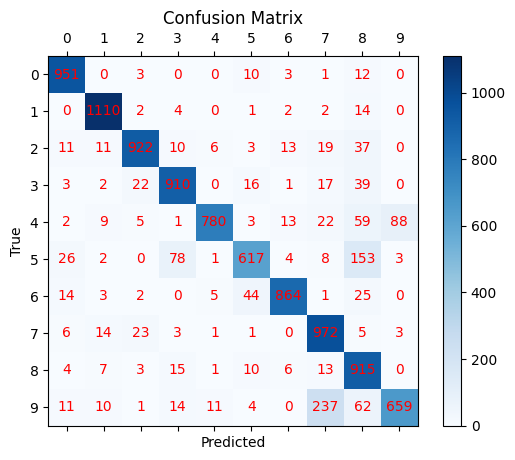

Learning Rate: 0.33, Hidden Layer Size: 32, Epochs: 32, 
Final Training Loss: 0.24945803620919174, Final Testing Loss: 0.26903772948396293, Final Accuracy: 92.45%
 


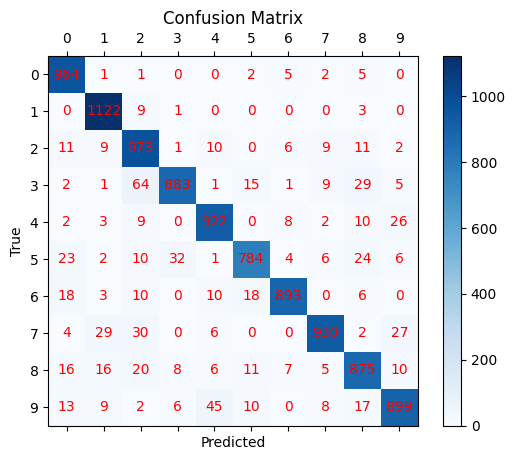

Learning Rate: 0.66, Hidden Layer Size: 8, Epochs: 32, 
Final Training Loss: 1.206394434691121, Final Testing Loss: 1.40450768507513, Final Accuracy: 38.690000000000005%
 


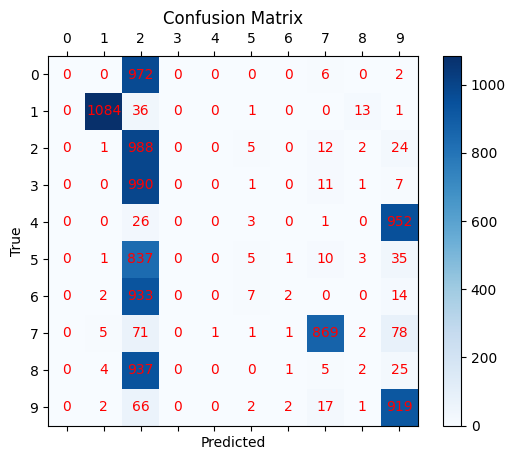

Learning Rate: 0.66, Hidden Layer Size: 16, Epochs: 32, 
Final Training Loss: 1.3130150178297464, Final Testing Loss: 1.5571281306091005, Final Accuracy: 32.519999999999996%
 


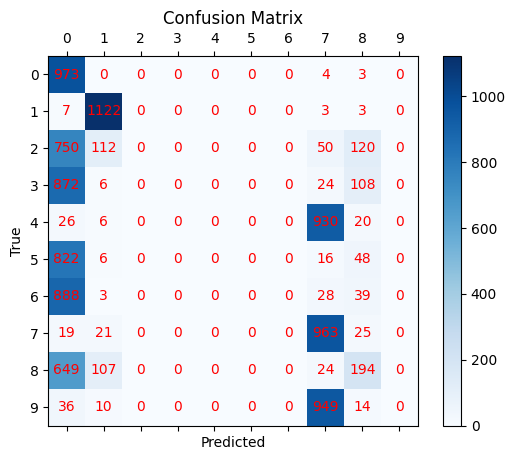

Learning Rate: 0.66, Hidden Layer Size: 32, Epochs: 32, 
Final Training Loss: 0.42357506520637433, Final Testing Loss: 0.381655690391124, Final Accuracy: 89.92%
 


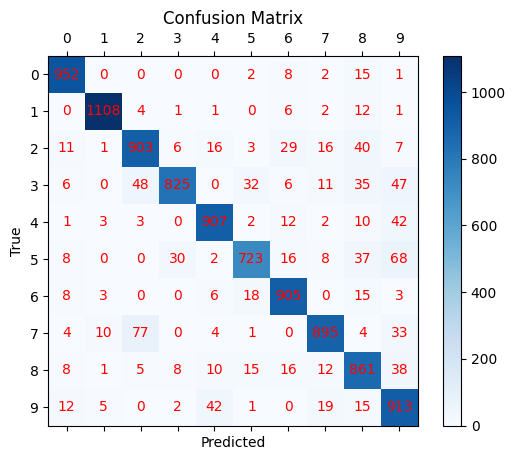

In [104]:
learning_rates = np.array([0.11, 0.33, 0.66])
hidden_sizes = np.array([8, 16, 32])

r_learning_rates = []
r_hidden_sizes = []
r_training_losses = []
r_testing_losses = []
r_accuracies = []

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        training_losses, testing_losses, accuracies = train_with_epoch(hidden_size=hidden_size, learning_rate=learning_rate)
        r_learning_rates.append(learning_rate)
        r_hidden_sizes.append(hidden_size)
        r_training_losses.append(training_losses)
        r_testing_losses.append(testing_losses)
        r_accuracies.append(accuracies)


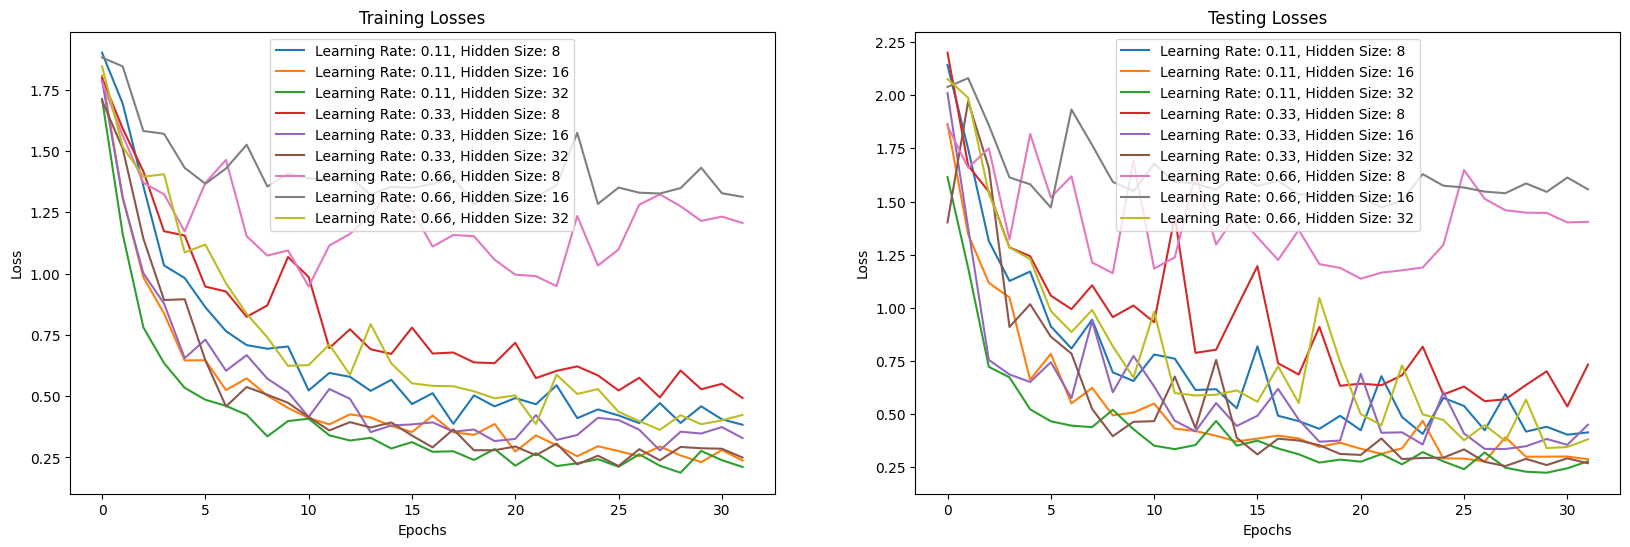

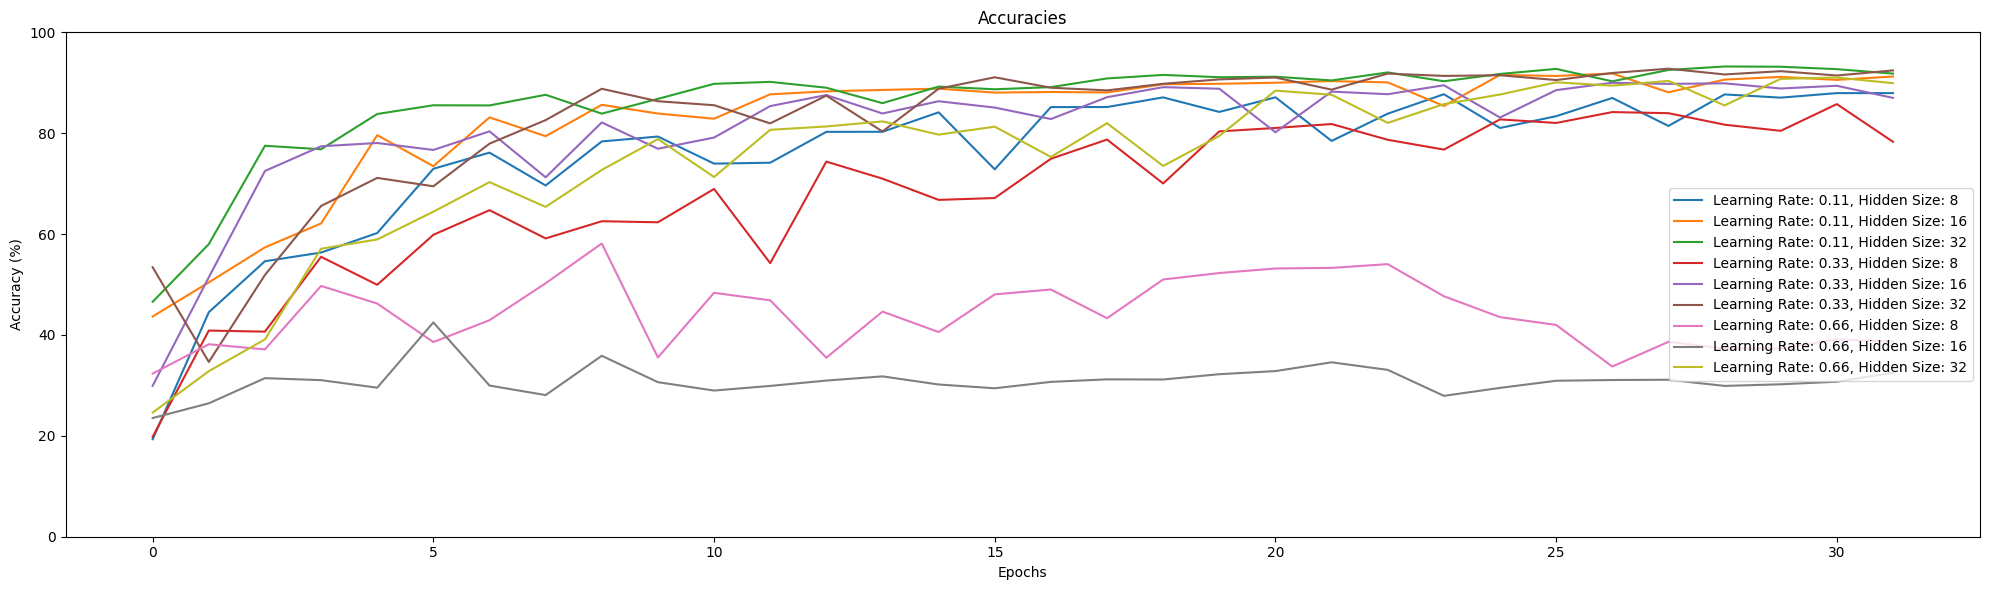

In [105]:
plt.figure(figsize=(20, 6))

for i in range(len(r_learning_rates)):
    label = f'Learning Rate: {r_learning_rates[i]}, Hidden Size: {r_hidden_sizes[i]}'

    plt.subplot(1, 2, 1)
    plt.plot(r_training_losses[i], label=label)
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(r_testing_losses[i], label=label)
    plt.title('Testing Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.figure(figsize=(20, 6))

for i in range(len(r_learning_rates)):
    label = f'Learning Rate: {r_learning_rates[i]}, Hidden Size: {r_hidden_sizes[i]}'

    plt.plot(r_accuracies[i], label=label)
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100) 
    plt.legend()

plt.tight_layout()
plt.show()
